In [1]:
# Get all the data from the testing and training data sets
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import glob
import matplotlib.image as mpimg

# TODO: Fill this in based on where you saved the training and testing data

# Data set locations and paths
trainingPath = "TrainingData/train.p"
testingPath = "TrainingData/test.p"

# Get the data from the data sets using pickle to read them in
with open(trainingPath, mode="rb") as training_data:
    train = pickle.load(training_data)

with open(testingPath, mode="rb") as testing_data:
    test = pickle.load(testing_data)


    
# Create the features and labels for the data and link them
x_train, y_train = train['features'], train['labels']
x_test, y_test = test['features'], test['labels']

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


x_train shape: (34799, 32, 32, 3)
y_train shape: (34799,)
x_test shape: (12630, 32, 32, 3)
y_test shape: (12630,)


In [2]:
# Define number of training samples and number of testing samples
num_train = len(x_train)
num_test = len(x_test)
# Define the number of classes (only the unique vales in y sets)
num_classes = len(np.unique(y_train))

# Define the image shape and data shape
image_shape = x_train[0].shape
print("Num of Training Samples:{} - Num of Test Sample:{} - Num Of classes:{}".format(num_train, num_test, num_classes))

Num of Training Samples:34799 - Num of Test Sample:12630 - Num Of classes:43


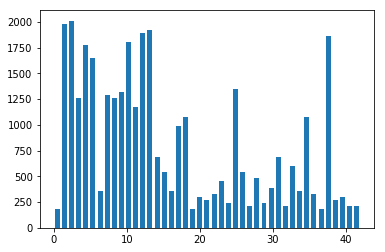

In [3]:
# histogram of label frequency Simple data exploration
hist, bins = np.histogram(y_train, bins=num_classes)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

In [4]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

# Convert to grayscale
x_train_rgb = x_train
x_train_gry = np.sum(x_train/3, axis=3, keepdims=True)

x_test_rgb = x_test
x_test_gry = np.sum(x_test/3, axis=3, keepdims=True)

print('RGB:', x_train_rgb.shape)
print('Grayscale:', x_train_gry.shape)

x_train = x_train_gry
x_test = x_test_gry

RGB: (34799, 32, 32, 3)
Grayscale: (34799, 32, 32, 1)


In [5]:
## Normalize the train and test datasets to (-1,1)

x_train_normalized = (x_train - 128)/128 
x_test_normalized = (x_test - 128)/128


In [6]:
## Shuffle the training dataset and create the validation set
# Validatioin set will not be used by Training 

x_train_normalized, y_train = shuffle(x_train_normalized, y_train)
x_train, x_validation, y_train, y_validation = train_test_split(x_train_normalized, y_train, 
                                                                test_size=0.20, random_state=42)

print("Old X_train size:",len(x_train_normalized))
print("New X_train size:",len(x_train))
print("X_validation size:",len(x_validation))

Old X_train size: 34799
New X_train size: 27839
X_validation size: 6960


In [7]:
# Build LeNET Model
EPOCHS = 60
BATCH_SIZE = 100
rate = 0.0009 # Learning rate

tf.reset_default_graph() 
# Tensor placehoders 
x = tf.placeholder(tf.float32, (None, 32, 32, 1)) # Define shape of a image 32X32
y = tf.placeholder(tf.int32, (None))              # Class label
keep_prob = tf.placeholder(tf.float32)            # probability to keep units
one_hot_y = tf.one_hot(y, 43)

In [17]:
def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    W1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma), name="W1")
    x = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='VALID')
    b1 = tf.Variable(tf.zeros(6), name="b1")
    x = tf.nn.bias_add(x, b1)
    print("layer 1 shape:",x.get_shape())

    # Activation function.
    x = tf.nn.relu(x)
    
    # Max Pooling. Input = 28x28x6. Output = 14x14x6.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    layer1 = x
    
    # Layer 2: Convolutional. Output = 10x10x16.
    W2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma), name="W2")
    x = tf.nn.conv2d(x, W2, strides=[1, 1, 1, 1], padding='VALID')
    b2 = tf.Variable(tf.zeros(16), name="b2")
    x = tf.nn.bias_add(x, b2)
                     
    # Activation function.
    x = tf.nn.relu(x)

    # Max Pooling. Input = 10x10x16. Output = 5x5x16.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    layer2 = x
    
    # Layer 3: Convolutional. Output = 1x1x400.
    W3 = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 400), mean = mu, stddev = sigma), name="W3")
    x = tf.nn.conv2d(x, W3, strides=[1, 1, 1, 1], padding='VALID')
    b3 = tf.Variable(tf.zeros(400), name="b3")
    x = tf.nn.bias_add(x, b3)
                     
    # Activation function.
    x = tf.nn.relu(x)
    layer3 = x

    # Flatten. Input = 5x5x16. Output = 400.
    layer2flat = flatten(layer2)
    print("layer2flat shape:",layer2flat.get_shape())
    
    # Flatten x. Input = 1x1x400. Output = 400.
    xflat = flatten(x)
    print("xflat shape:",xflat.get_shape())
    
    # Concat layer2flat and x. Input = 400 + 400. Output = 800
    x = tf.concat([xflat, layer2flat], 1)
    print("x shape:",x.get_shape())
    
    # Dropout
    x = tf.nn.dropout(x, keep_prob)
    
    # Layer 4: Fully Connected. Input = 800. Output = 43.
    W4 = tf.Variable(tf.truncated_normal(shape=(800, 43), mean = mu, stddev = sigma), name="W4")
    b4 = tf.Variable(tf.zeros(43), name="b4")    
    logits = tf.add(tf.matmul(x, W4), b4)
    
   
    
    return logits


In [18]:
# Start the training

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

layer 1 shape: (?, 28, 28, 6)
layer2flat shape: (?, 400)
xflat shape: (?, 400)
x shape: (?, 800)


In [19]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

In [20]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [22]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(x_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        x_train, y_train = shuffle(x_validation, y_validation)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = x_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(x_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess,'.\lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.426

EPOCH 2 ...
Validation Accuracy = 0.674

EPOCH 3 ...
Validation Accuracy = 0.825

EPOCH 4 ...
Validation Accuracy = 0.878

EPOCH 5 ...
Validation Accuracy = 0.919

EPOCH 6 ...
Validation Accuracy = 0.941

EPOCH 7 ...
Validation Accuracy = 0.948

EPOCH 8 ...
Validation Accuracy = 0.957

EPOCH 9 ...
Validation Accuracy = 0.966

EPOCH 10 ...
Validation Accuracy = 0.971

EPOCH 11 ...
Validation Accuracy = 0.977

EPOCH 12 ...
Validation Accuracy = 0.984

EPOCH 13 ...
Validation Accuracy = 0.986

EPOCH 14 ...
Validation Accuracy = 0.985

EPOCH 15 ...
Validation Accuracy = 0.988

EPOCH 16 ...
Validation Accuracy = 0.992

EPOCH 17 ...
Validation Accuracy = 0.991

EPOCH 18 ...
Validation Accuracy = 0.995

EPOCH 19 ...
Validation Accuracy = 0.995

EPOCH 20 ...
Validation Accuracy = 0.996

EPOCH 21 ...
Validation Accuracy = 0.995

EPOCH 22 ...
Validation Accuracy = 0.997

EPOCH 23 ...
Validation Accuracy = 0.997

EPOCH 24 ...
Validation Accura

In [23]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver2 = tf.train.import_meta_graph('./lenet.meta')
    saver2.restore(sess, "./lenet")
    test_accuracy = evaluate(x_test_normalized, y_test)
    print("Test Set Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet
Test Set Accuracy = 0.911
